In [1]:
import os
import utils
import model_scoring
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input, BatchNormalization

from sklearn.preprocessing import StandardScaler

Using plaidml.keras.backend backend.


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
MODEL_LOCATION = 'checkpoints/jfk_model'

In [4]:
train, test = utils.load_data(hourly=True)

Now, we will normalize the data.

In [5]:
# # scaler = StandardScaler()
# # train = scaler.fit_transform(train)
# # test = scaler.transform(test)

# # list(train.columns)

mean = train.mean(axis=0)
std = train.std(axis=0)

# train -= mean
# test -= mean
# train /= std
# test /= std

utils.preprocess(train, mean, std)
utils.preprocess(test, mean, std)

# train['target'] -= mean.target
# train['target'] /= std.target
# test['target'] -= mean.target
# test['target'] /= std.target


# # skip normalization and let batch normalization take over)
# utils.preprocess(train, normalize=False)
# utils.preprocess(test, normalize=False)

In [6]:
labels = train.pop('target')
train.head()

,temp,dwpt,heat_idx,rh,pressure,vis,wc,wdir,wspd,prcp,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2009-05-10 10:00:00,0.254668,-0.179754,0.234085,-0.975517,-0.724918,0.360180,0.342674,1.036122,0.780809,-0.146297,...,0,0,1,0,0,0,0,0,0,0
2014-12-25 20:00:00,-0.474882,-0.603607,-0.478673,-0.535035,0.073934,0.360180,-0.500869,0.660871,0.422196,-0.146297,...,0,0,0,0,0,0,0,0,0,1
2011-10-20 03:00:00,0.591383,1.303734,0.563051,2.052795,-2.785114,-3.466023,0.623855,-0.277256,0.780809,-0.146297,...,0,0,0,0,0,0,0,1,0,0
2007-06-18 02:00:00,1.208695,1.091808,1.275809,-0.094554,-0.514694,0.360180,1.139354,1.317561,-1.012255,-0.146297,...,0,0,0,1,0,0,0,0,0,0
2008-05-12 17:00:00,-0.082048,-0.232735,-0.094880,-0.479975,-1.397635,0.360180,0.061493,-1.215384,2.573874,-0.146297,...,0,0,1,0,0,0,0,0,0,0


In [64]:
main_input = Input(shape=(train.shape[1],), name='main_input')
# x = BatchNormalization()(main_input)
x = Dense(512, activation='relu')(main_input)
# x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)


output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 478)               0         
_________________________________________________________________
dense_222 (Dense)            (None, 512)               245248    
_________________________________________________________________
dense_223 (Dense)            (None, 64)                32832     
_________________________________________________________________
dense_224 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_225 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_226 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_227 (Dense)            (None, 64)                4160      
__________

In [65]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=MODEL_LOCATION,
    save_weights_only=True,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True,
)

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mse'])
history = model.fit([train], labels,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[model_checkpoint_callback]
                   )

Train on 95077 samples, validate on 23770 samples
Epoch 1/30
95077/95077 [==============================] - 23s 247us/step - loss: 0.1911 - mean_squared_error: 0.1911 - val_loss: 0.2687 - val_mean_squared_error: 0.2687
Epoch 2/30
95077/95077 [==============================] - 24s 251us/step - loss: 0.0813 - mean_squared_error: 0.0813 - val_loss: 0.1472 - val_mean_squared_error: 0.1472
Epoch 3/30
95077/95077 [==============================] - 23s 240us/step - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.1631 - val_mean_squared_error: 0.1631
Epoch 4/30
95077/95077 [==============================] - 23s 240us/step - loss: 0.0595 - mean_squared_error: 0.0595 - val_loss: 0.0942 - val_mean_squared_error: 0.0942
Epoch 5/30
95077/95077 [==============================] - 23s 238us/step - loss: 0.0546 - mean_squared_error: 0.0546 - val_loss: 0.0578 - val_mean_squared_error: 0.0578
Epoch 6/30
95077/95077 [==============================] - 23s 238us/step - loss: 0.0510 - mean_squared_er

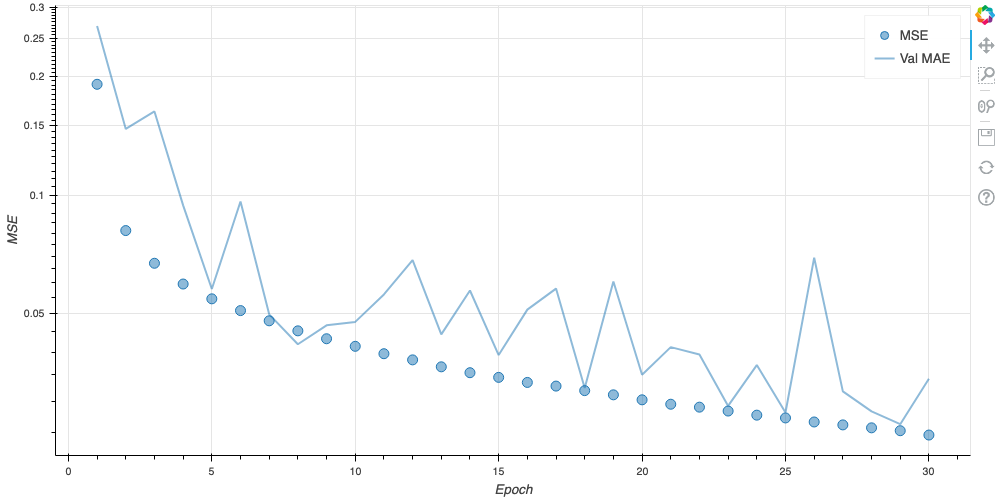

In [66]:
source = pd.DataFrame(history.history)
source['epoch'] = source.index + 1
acc_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='MSE', y_axis_type='log')
acc_plot.circle(x='epoch', y='mean_squared_error', source=source, size=10, fill_alpha=.5, legend_label='MSE')
acc_plot.line(x='epoch', y='val_mean_squared_error', source=source, line_width=2, legend_label='Val MAE', alpha=0.5)
# show(acc_plot)
get_screenshot_as_png(acc_plot, driver=None)

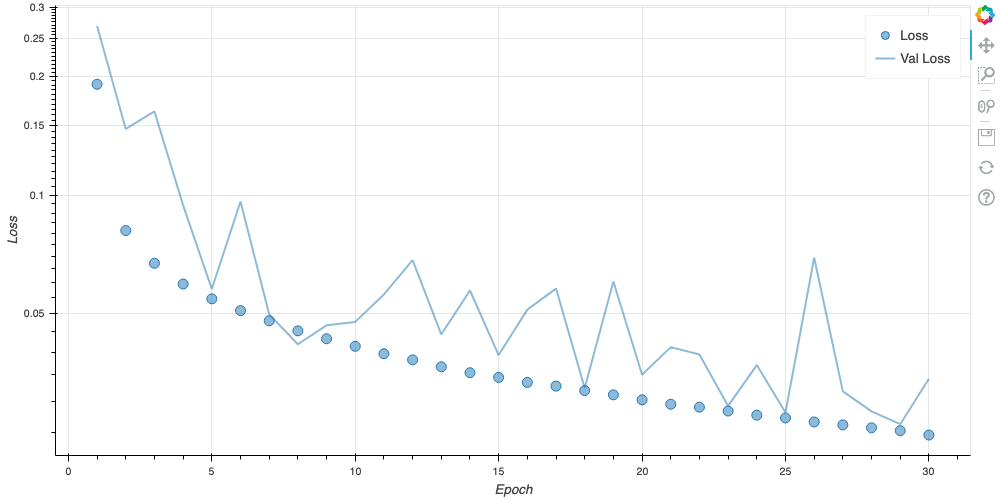

In [67]:
loss_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='Loss', y_axis_type='log')
loss_plot.circle(x='epoch', y='loss', source=source, size=10, fill_alpha=.5, legend_label='Loss')
loss_plot.line(x='epoch', y='val_loss', source=source, line_width=2, legend_label='Val Loss', alpha=0.5)
# show(loss_plot)
get_screenshot_as_png(loss_plot, driver=None)

Previously achieved with NOAA weather data:  
  
Total prediction error: 113288.0  
Total ISOLF prediction error: 63146.0  
Percentage of time the model outperformed the NYISO model: 31.76 (175/551)  
  
  
Hourly results from before:  
  
Total prediction error: 2139681.0
Total ISOLF prediction error: 2174812.0
Percentage of time the model outperformed the NYISO model: 46.51 (6142/13205)

In [68]:
model.load_weights(MODEL_LOCATION)
predictions = model.predict(test.copy().drop(columns=['target']))
isolf = utils.isolf_hourly(lookahead=1)
results = test.copy()
results['prediction'] = predictions
results = results.join(isolf, how='inner')
results['target'] *= std.target
results['target'] += mean.target
results['prediction'] *= std.target
results['prediction'] += mean.target
results['date'] = results.index
results = results.astype({'prediction': 'float'})

results, pred_plot = model_scoring.eval(results)

Total prediction error: 1988970.0
Total ISOLF prediction error: 2174812.0
Percentage of time the model outperformed the NYISO model: 49.39 (6522/13205)


In [69]:
model.save('checkpoints/jfk_model.h5')

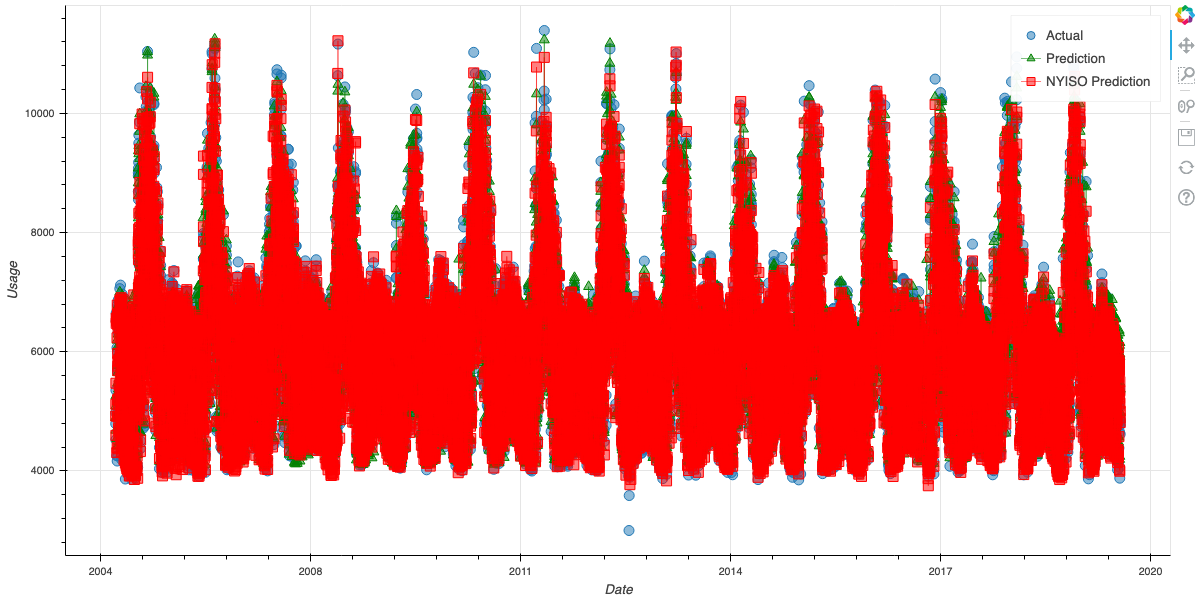

In [12]:
# show(pred_plot)
get_screenshot_as_png(pred_plot, driver=None)

In [13]:
results

,target,temp,dwpt,heat_idx,rh,pressure,vis,wc,wdir,wspd,...,month_8,month_9,month_10,month_11,month_12,prediction,nyiso_prediction,date,prediction_error,nyiso_prediction_error
2011-08-01 22:00:00,8777.583,1.040337,1.197771,1.001671,0.511109,-0.851052,0.360180,0.998763,-1.121571,-0.832949,...,1,0,0,0,0,7284.213379,8526,2011-08-01 22:00:00,-1493.369621,-251.583
2018-09-07 07:00:00,8064.692,1.096456,1.568643,1.056499,1.392072,0.494382,0.360180,1.045627,-1.309197,-0.115723,...,0,1,0,0,0,6709.807617,7572,2018-09-07 07:00:00,-1354.884383,-492.692
2008-07-03 09:00:00,8392.483,1.096456,1.038826,1.056499,0.015567,-0.178335,0.360180,1.045627,0.285620,0.780809,...,0,0,0,0,0,7110.836914,7886,2008-07-03 09:00:00,-1281.646086,-506.483
2009-08-21 20:00:00,8890.233,1.096456,1.568643,1.056499,1.392072,-0.430604,0.360180,1.045627,0.097995,-0.115723,...,1,0,0,0,0,7642.947266,8886,2009-08-21 20:00:00,-1247.285734,-4.233
2011-07-20 21:00:00,9066.825,1.040337,1.462680,1.001671,1.226892,-0.724918,-1.074646,0.998763,-0.183444,-0.115723,...,0,0,0,0,0,7855.394531,8940,2011-07-20 21:00:00,-1211.430469,-126.825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-05-29 08:00:00,5204.983,0.871979,0.985844,0.837188,0.345928,0.452337,-1.074646,0.858173,0.004182,-0.653642,...,0,0,0,0,0,6821.416016,5032,2006-05-29 08:00:00,1616.433016,-172.983
2006-05-29 13:00:00,6619.858,1.713768,0.985844,1.659602,-1.085637,0.158024,0.360180,1.561125,0.660871,-1.012255,...,0,0,0,0,0,8246.289062,6395,2006-05-29 13:00:00,1626.431062,-224.858
2007-09-03 16:00:00,7100.550,1.657648,0.879881,1.604774,-1.195758,-0.178335,0.360180,1.514262,0.473246,0.960116,...,0,1,0,0,0,8764.978516,7250,2007-09-03 16:00:00,1664.428516,149.450
2012-10-30 19:00:00,4364.900,-0.082048,0.244100,-0.094880,0.621229,-2.322621,0.360180,0.061493,0.097995,-0.653642,...,0,0,1,0,0,6144.496582,6427,2012-10-30 19:00:00,1779.596582,2062.100
